In [233]:
import numpy as np

def get_one_cluster(arr, size, start_row, start_col, diff, visited):
    stack = [(None, (start_row, start_col))]
    cluster = np.full(size, False)
    while stack:
        prev, curr = stack.pop()
        if not visited[*curr]:
            if not prev or (np.linalg.norm(arr[*curr] - arr[*prev]) <= diff):
                cluster[*curr] = True
                visited[*curr] = True
                row, col = curr
                if row + 1 < size[0]: stack.append((curr, (row + 1, col)))
                if row - 1 >= 0: stack.append((curr, (row - 1, col)))
                if col + 1 < size[1]: stack.append((curr, (row, col + 1)))
                if col - 1 >= 0: stack.append((curr, (row, col - 1)))
    return cluster, visited


def get_clusters(img, diff, treshold):
    arr = np.array(img, dtype=np.int64)
    clusters = []
    visited = np.full(img.size, False)
    for row in range(img.size[0]):
        for col in range(img.size[1]):
            if not visited[row, col]:
                cluster, visited = get_one_cluster(arr, img.size, row, col, diff, visited)
                if cluster.sum() > treshold:
                    clusters.append(cluster)
    return clusters


def add_clusters(clusters):
    res = np.zeros(clusters[0].shape, dtype=int)
    for num, cluster in enumerate(clusters, start=1):
        res += cluster * num
    return res


def reconstruct_avg(original, clusters):
    arr = np.array(original, dtype=np.uint8)
    for cluster in clusters:
        avg = np.average(arr, (0, 1,), weights=cluster)
        arr[cluster] = avg
    arr[~sum(clusters).astype(np.True_)] = [0, 0, 0]
    return arr

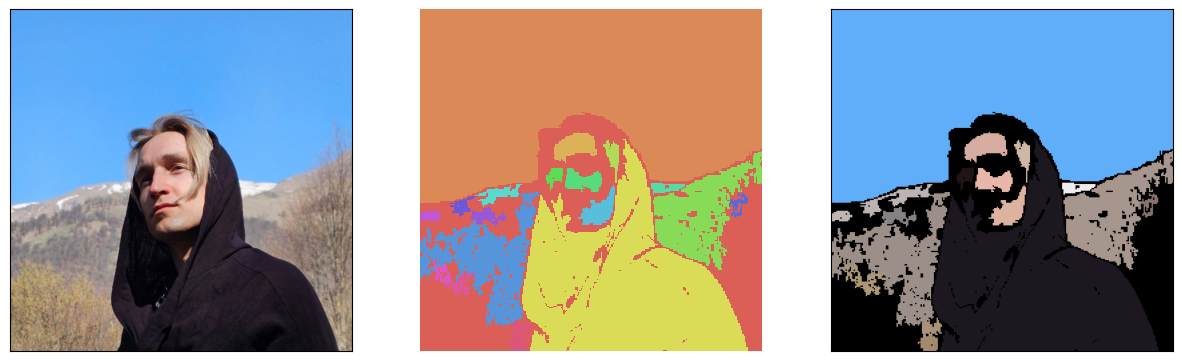

In [242]:
import PIL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

img = PIL.Image.open('ava.jpeg')
size = (256, 256)
img_small = img.resize((size))

clusters = get_clusters(img_small, 10, 100)
res = add_clusters(clusters)
averaged = reconstruct_avg(img_small, clusters)
averaged_img = PIL.Image.fromarray(averaged)

fig, (axe1, axe2, axe3) = plt.subplots(1, 3)
fig.set_size_inches(15, 75)
axe1.get_xaxis().set_visible(False)
axe1.get_yaxis().set_visible(False)
axe1.imshow(img)
sns.heatmap(res, yticklabels=False, xticklabels=False, square=True, cmap=sns.color_palette('hls', len(clusters)), cbar=False, ax=axe2)
axe3.get_xaxis().set_visible(False)
axe3.get_yaxis().set_visible(False)
axe3.imshow(averaged_img)

<Axes: >

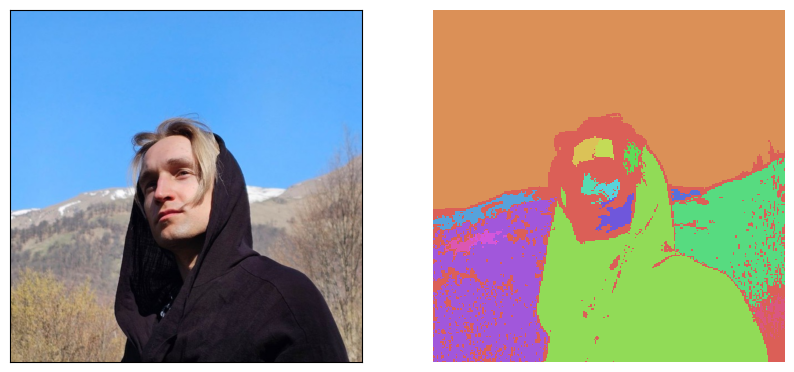

In [251]:
import PIL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN


def make_X_with_coords(arr, size):
    res = []
    for row in range(size[0]):
        for col in range(size[1]):
            res.append(list(arr[row, col]) + [row, col])
    return np.array(res, dtype=np.uint8)


img = PIL.Image.open('ava.jpeg')
size = (256, 256)
img_small = img.resize((size))
arr = np.array(img_small)
# X = arr.reshape(size[0] * size[1], 3)
X = make_X_with_coords(arr, size)

model = DBSCAN(eps=12, min_samples=80)
res = model.fit_predict(X)
res = res.reshape(size)

fig, (axe1, axe2) = plt.subplots(1, 2)
fig.set_size_inches(10, 50)
axe1.get_xaxis().set_visible(False)
axe1.get_yaxis().set_visible(False)
axe1.imshow(img)
sns.heatmap(res, yticklabels=False, xticklabels=False, square=True, cmap=sns.color_palette('hls', res.max() + 2), cbar=False, ax=axe2)